# Cox生存分析

* `mydir`：自己的数据
* `ostime_column`: 数据对应的生存时间，不一定非的是OST，也可以是DST、FST等。
* `os`：生存状态，不一定非的是OS，也可以是DS、FS等。

In [1]:
from lifelines import CoxPHFitter
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df
from sklearn.model_selection import train_test_split
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.comp1 import fillna

task_type = 'Clinical_'
event_col = get_param_in_cwd('event_col', 'OS')
duration_col=get_param_in_cwd('duration_col', 'OSTime')
data = pd.read_csv('data/clinical.csv')
# data = normalize_df(data, not_norm='ID')
# label_data = pd.read_csv(get_param_in_cwd('label_file'))
# label_data = fillna(label_data, fill_mod='50%')
# data = pd.merge(data, label_data, on='ID', how='inner')
data

,ID,age,gender,T,N,M,Lauren_classification,Location,OS,OSTime,group
0,TCGA-BR-8368,84,0,1,0,0,0,0,0,131,test
1,TCGA-D7-8575,75,1,2,2,0,0,0,1,554,train
2,TCGA-VQ-A925,66,1,2,2,0,0,1,1,138,train
3,TCGA-RD-A7BT,66,1,2,3,0,0,0,1,262,train
4,TCGA-CD-A4MG,76,1,2,0,0,1,0,1,200,train
...,...,...,...,...,...,...,...,...,...,...,...
160,TCGA-RD-A8N6,78,0,1,2,0,0,1,1,272,train
161,TCGA-HU-A4GN,61,1,1,1,0,0,1,0,912,train
162,TCGA-BR-8484,61,1,3,1,0,0,0,1,766,test
163,TCGA-RD-A8NB,80,0,2,1,0,1,0,1,513,train


In [2]:
import numpy as np
import onekey_algo.custom.components as okcomp
from collections import OrderedDict

group_info = 'group'
train_data = data[(data[group_info] == 'train')]

# subsets = [s for s in label_data['group'].value_counts().index if s != 'train']
subsets = ['train', 'test']
val_datasets = OrderedDict()
for subset in subsets:
    val_data = data[data[group_info] == subset]
    val_datasets[subset] = val_data
    val_data.to_csv(f'features/{task_type}_{subset}_features_norm.csv', index=False)

print('，'.join([f"{subset}样本数：{d_.shape}" for subset, d_ in val_datasets.items()]))

train样本数：(115, 11)，test样本数：(50, 11)


## Cox概览

所有Cox回归的必要数据，主要关注的数据有3个
1. `Concordance`: c-index
2. `exp(coef)`: 每个特征对应的HR，同时也有期对应的95%分位数。
3. `p`: 表示特征是否显著。

In [3]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.01)
cph.fit(train_data[[c for c in train_data.columns if c not in ['ID', 'group']]], duration_col=duration_col, event_col=event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 62 right-censored observations>
             duration col = 'OSTime'
                event col = 'OS'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 115
number of events observed = 53
   partial log-likelihood = -200.25
         time fit was run = 2024-02-07 07:34:06 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age                     0.02       1.02       0.01            -0.01             0.04                 0.99                 1.05
gender                  0.37       1.44       0.29            -0.21             0.94                 0.81                 2.57
T                       0.58       1.79       0.23             0.12             1.04                 1.13                 2.82
N                       0.28       1.32       0.13             0.02             0.54                 1.02                 1.71
M                       0.80       2.22       0.45            -0.08             1.67                 0.93                 5.33
Lauren_classification   0.44       1.55       0.35            -0.25             1.12                 0.78                 3.07
Location               -0.49       0.62       0.32            -1.11             0.14                 0.33                 1.15

                        cmp to     z    p   -log2(p)
covariate                                           
age                       0.00  1.09 0.27       1.87
gender                    0.00  1.25 0.21       2.25
T                         0.00  2.49 0.01       6.31
N                         0.00  2.10 0.04       4.82
M                         0.00  1.79 0.07       3.75
Lauren_classification     0.00  1.25 0.21       2.25
Location                  0.00 -1.53 0.13       2.98
---
Concordance = 0.70
Partial AIC = 414.50
log-likelihood ratio test = 23.10 on 7 df
-log2(p) of ll-ratio test = 9.26

#### 输出每个特征的HR

In [4]:
cph.concordance_index_

0.7025298051759232

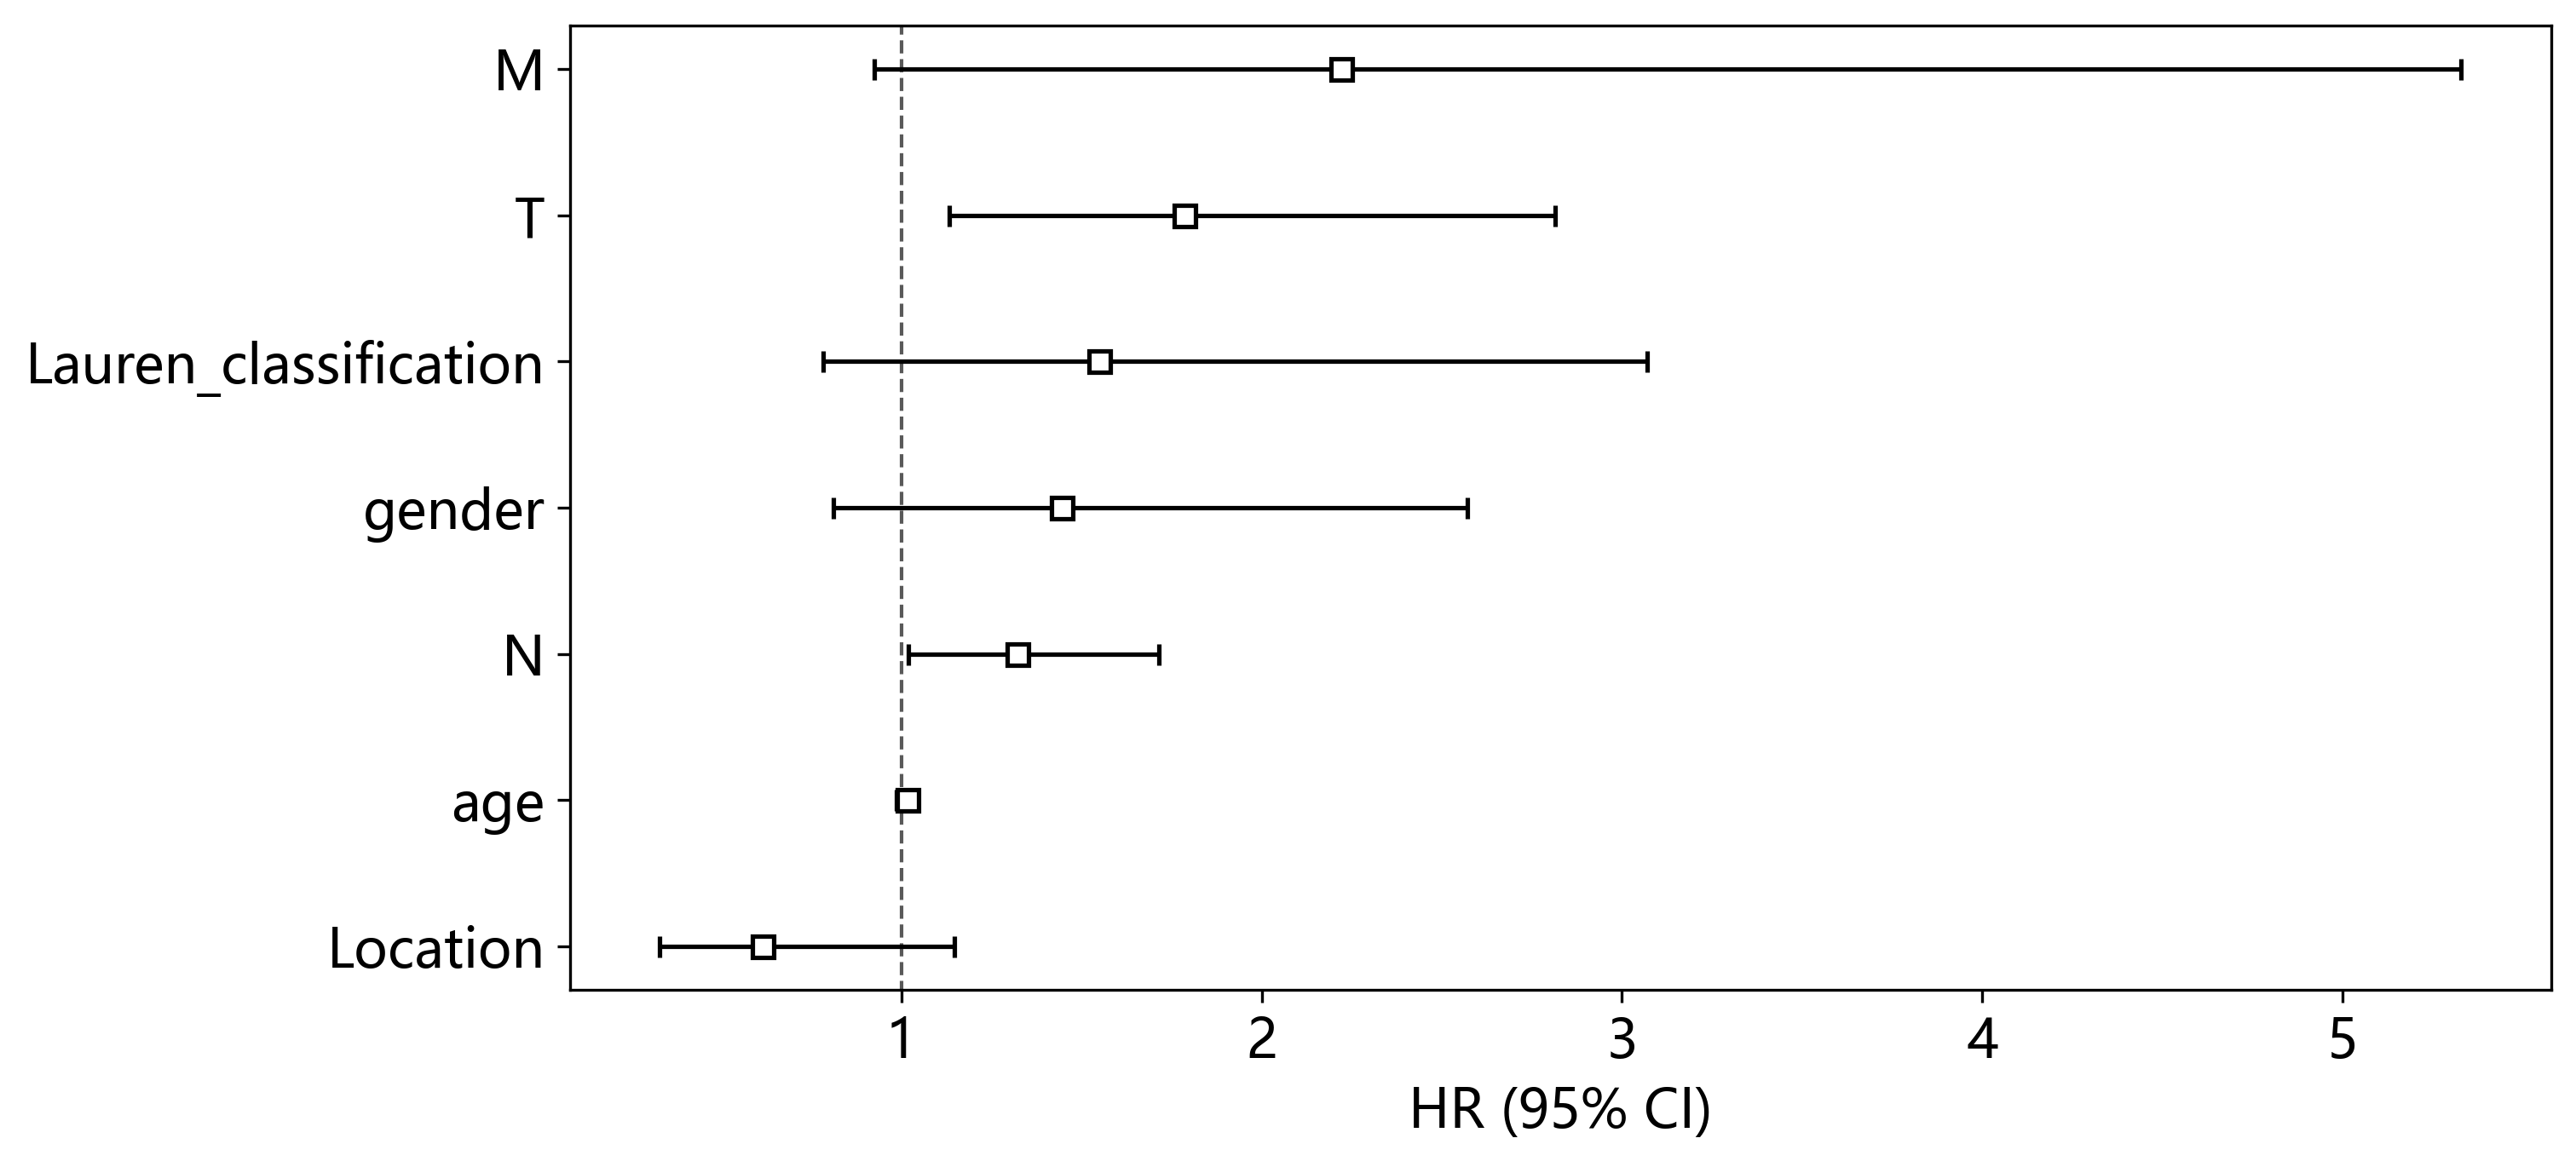

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
cph.plot(hazard_ratios=True)
plt.savefig('img/Clinic_feature_pvalue.svg')
plt.show()

# KM 曲线

根据HR进行分组，计算KM以及log ranktest

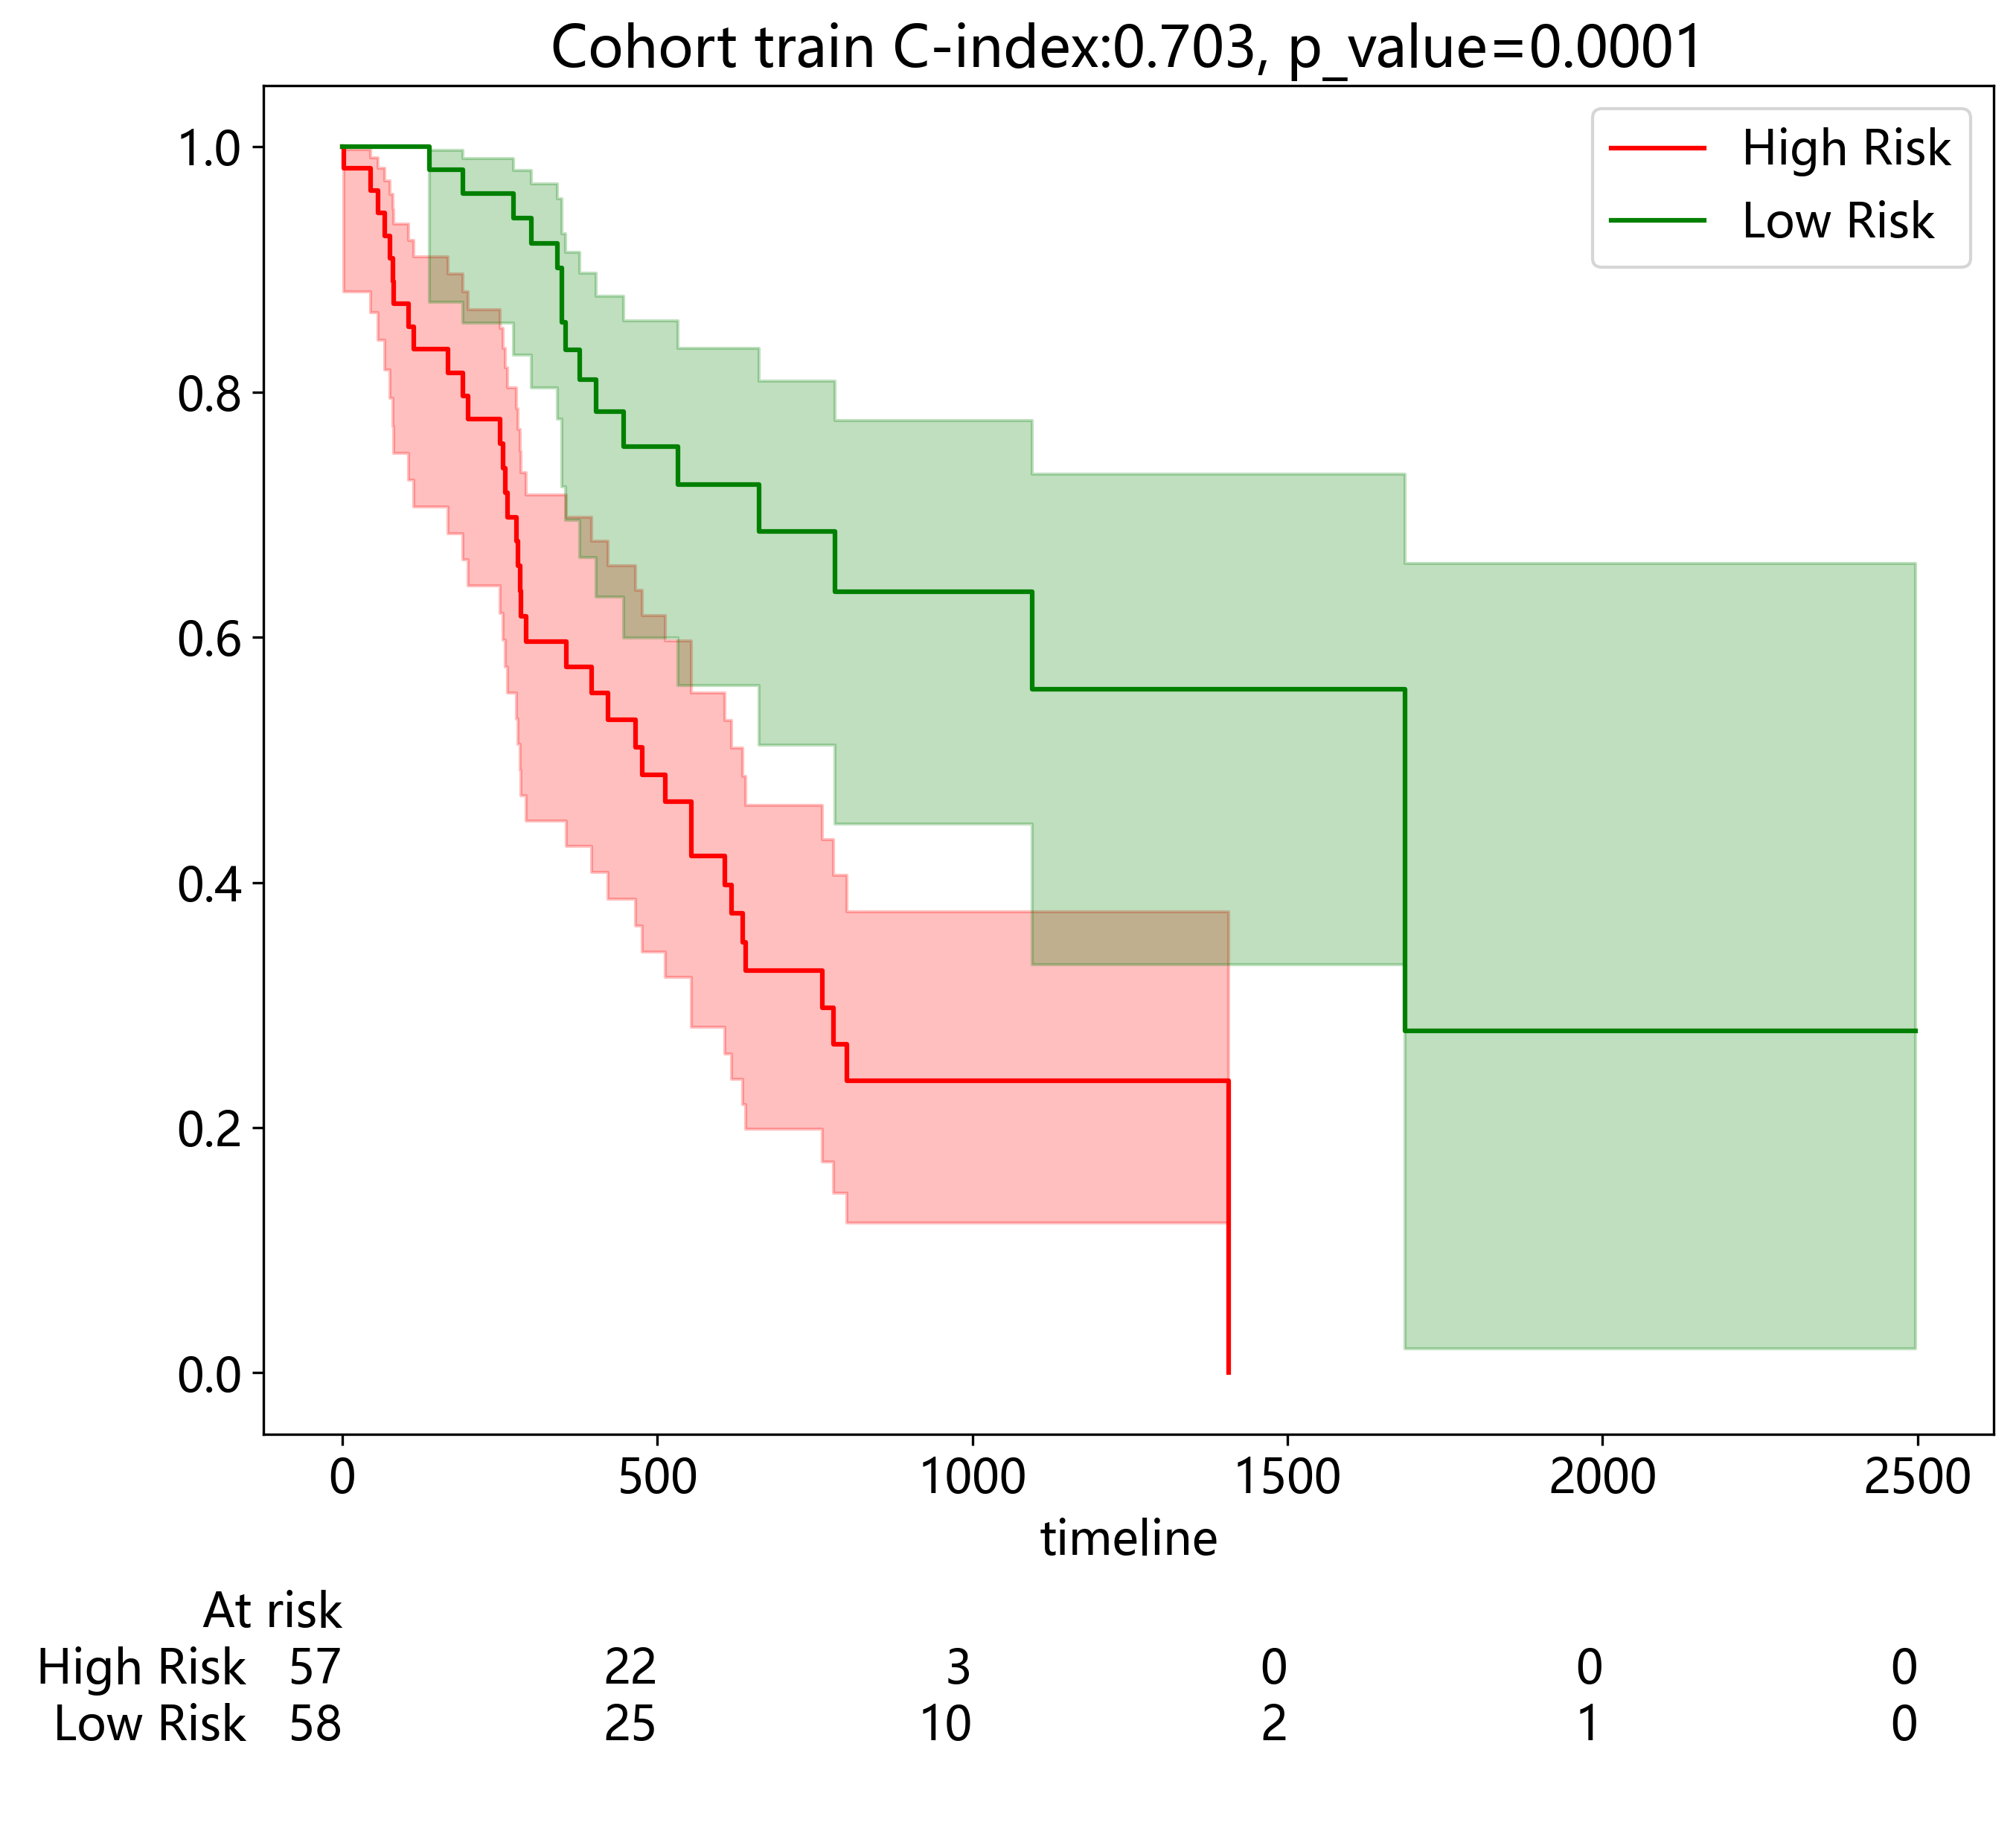

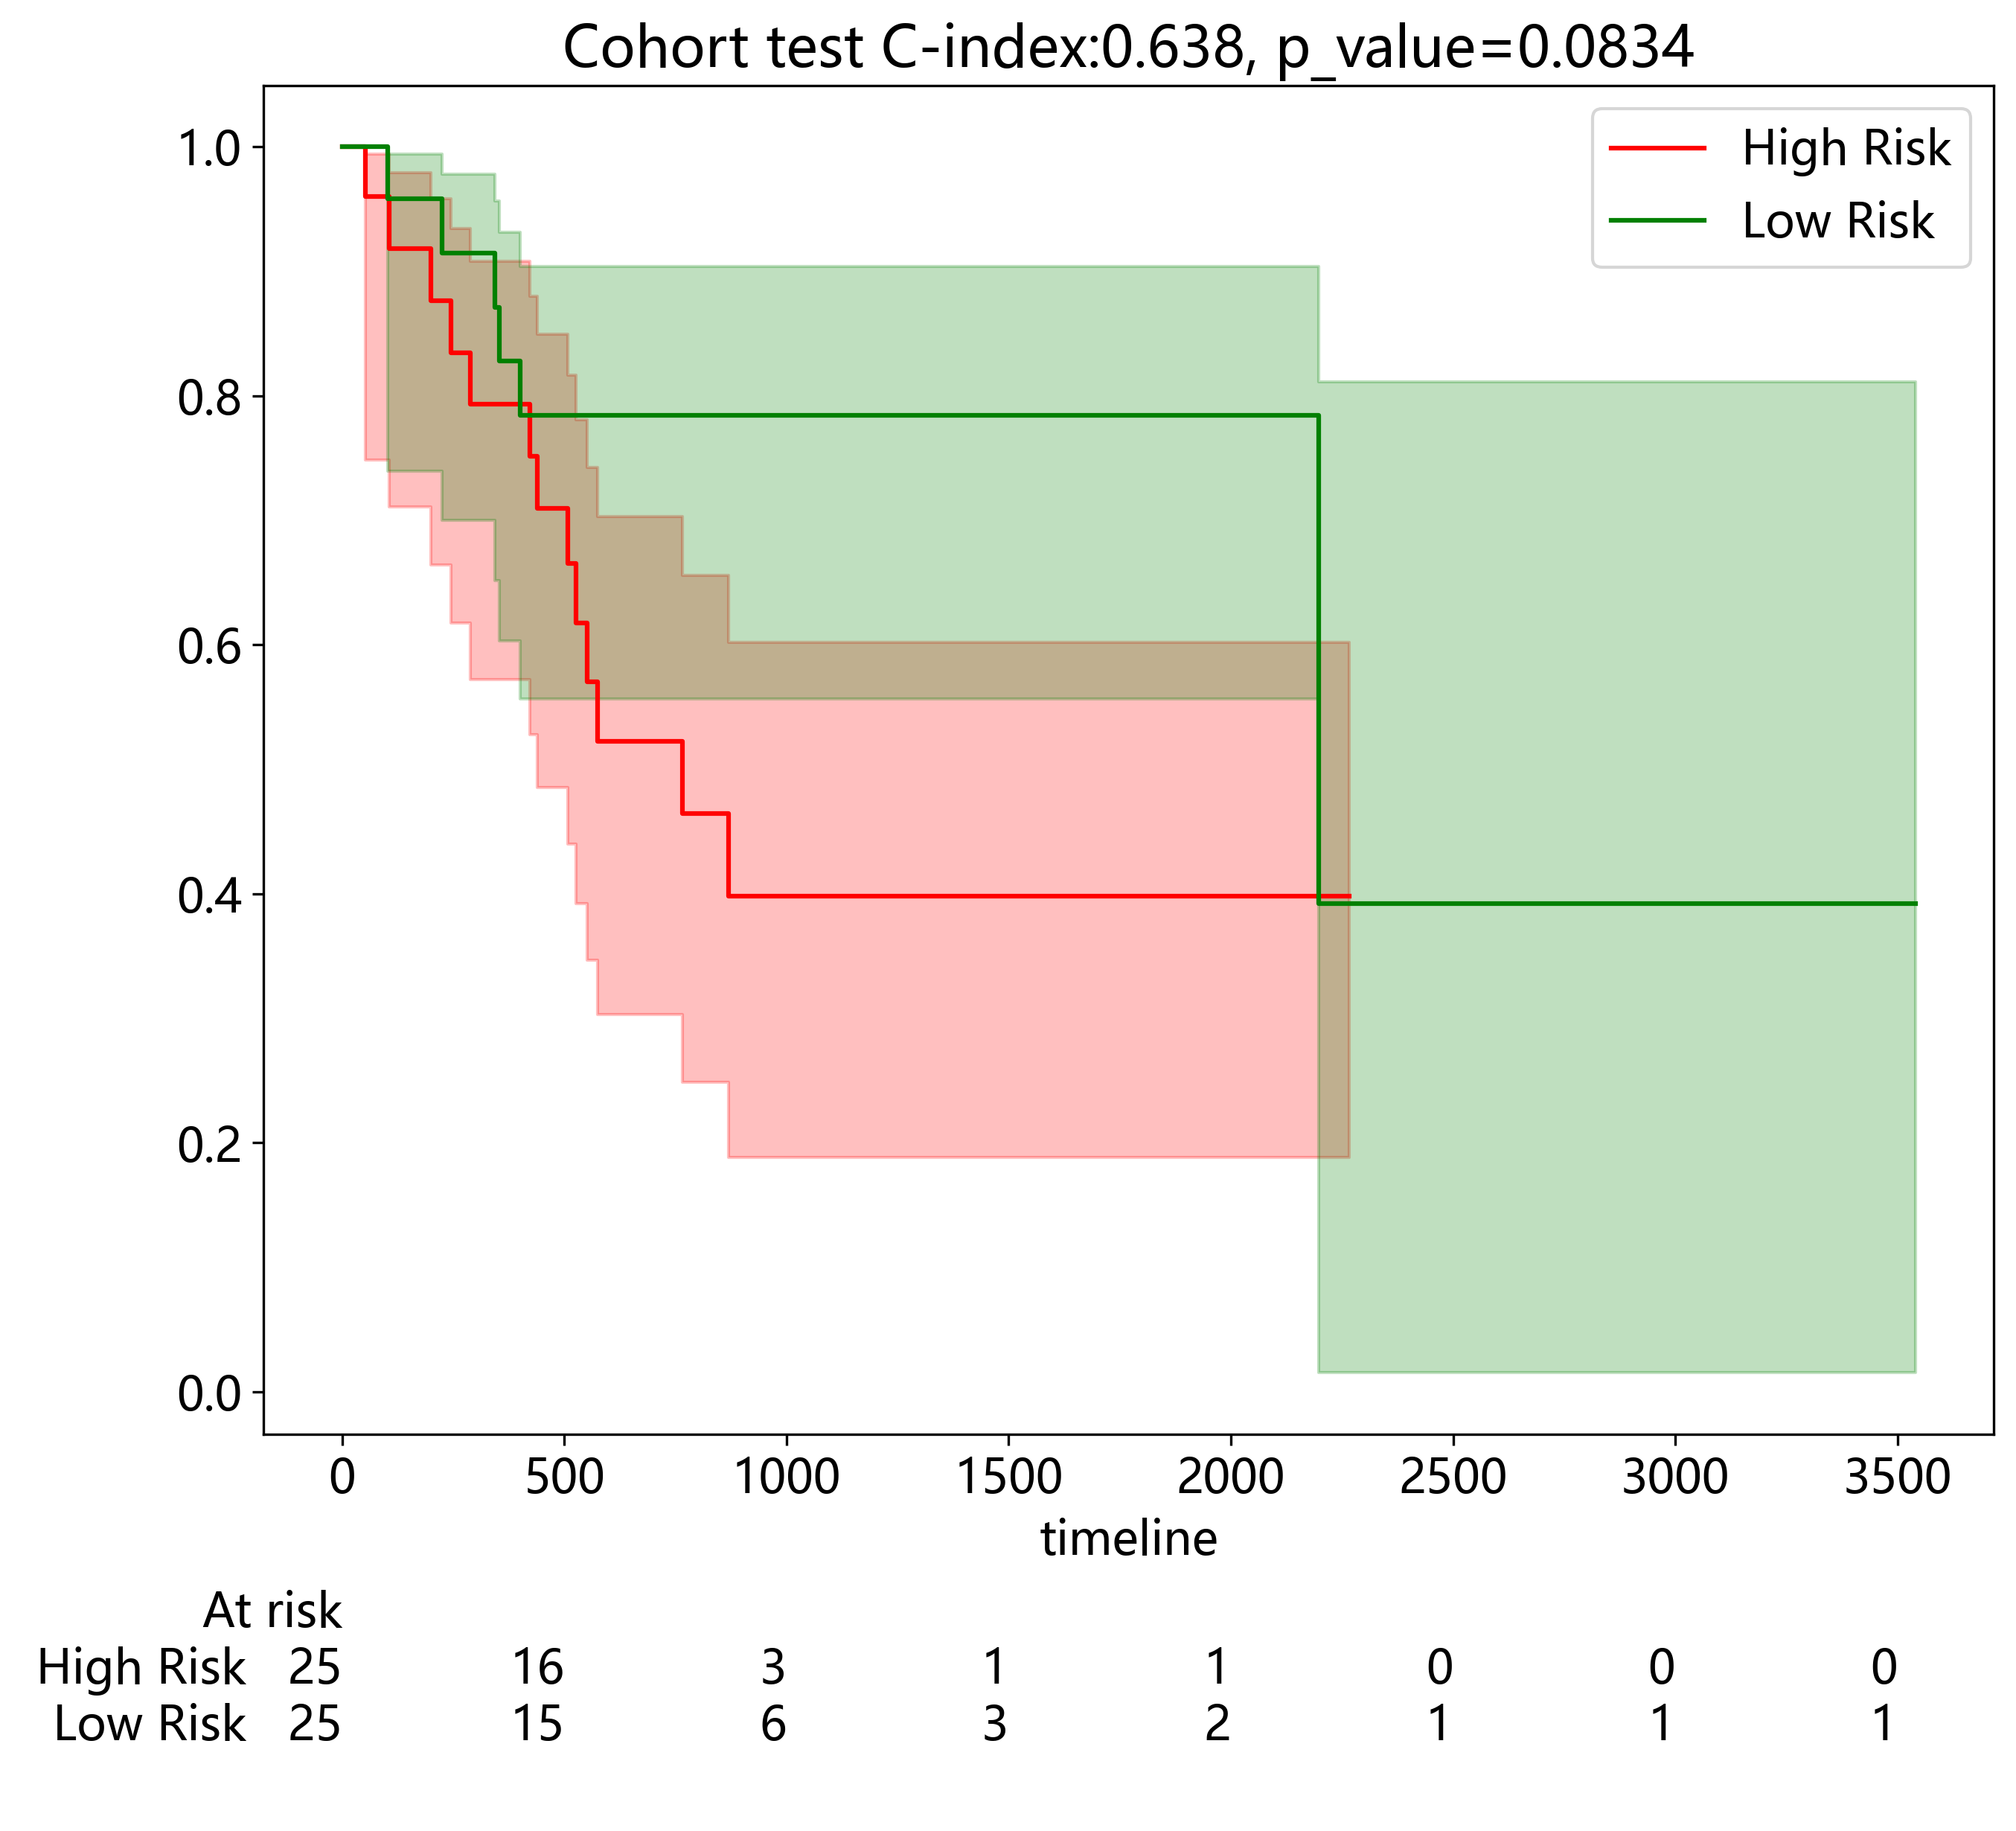

In [6]:
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

for subset, test_data in val_datasets.items():
    if subset == 'test_ex':
        continue
    c_index = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
#     y_pred = cph.predict_median(test_data[[c for c in test_data.columns if c != 'ID']])
#     cox_data = pd.concat([test_data, y_pred], axis=1)
#     mean = cox_data.describe()[0.5]['mean']
#     cox_data['HR'] = cox_data[0.5] < mean
    y_pred = cph.predict_partial_hazard(test_data[[c for c in test_data.columns if c != 'ID']])
    cox_data = pd.concat([test_data, y_pred], axis=1)
    mean = cox_data.describe()[0]['50%']
    cox_data['HR'] = cox_data[0] > mean
#     cox_data['HR'] = cox_data[0] > 1

    dem = (cox_data["HR"] == True)
    results = logrank_test(cox_data[duration_col][dem], cox_data[duration_col][~dem], 
                           event_observed_A=cox_data[event_col][dem], event_observed_B=cox_data[event_col][~dem])
    p_value = results.p_value
    plt.title(f"Cohort {subset} C-index:{c_index:.3f}, p_value={p_value:.4f}")
    if sum(dem):
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(cox_data[duration_col][dem], event_observed=cox_data[event_col][dem], label="High Risk")
        kmf_high.plot_survival_function(color='r')
    if sum(~dem):
        kmf_low = KaplanMeierFitter()
        kmf_low.fit(cox_data[duration_col][~dem], event_observed=cox_data[event_col][~dem], label="Low Risk")
        kmf_low.plot_survival_function(color='g')
    add_at_risk_counts(kmf_high, kmf_low, rows_to_show=['At risk'])
    plt.savefig(f'img/{task_type}KM_{subset}.svg', bbox_inches='tight')
    plt.show()

ICI =  0.2899023974696335
E50 =  0.24025095635474814
ICI =  0.27135461830172947
E50 =  0.23279791490966406


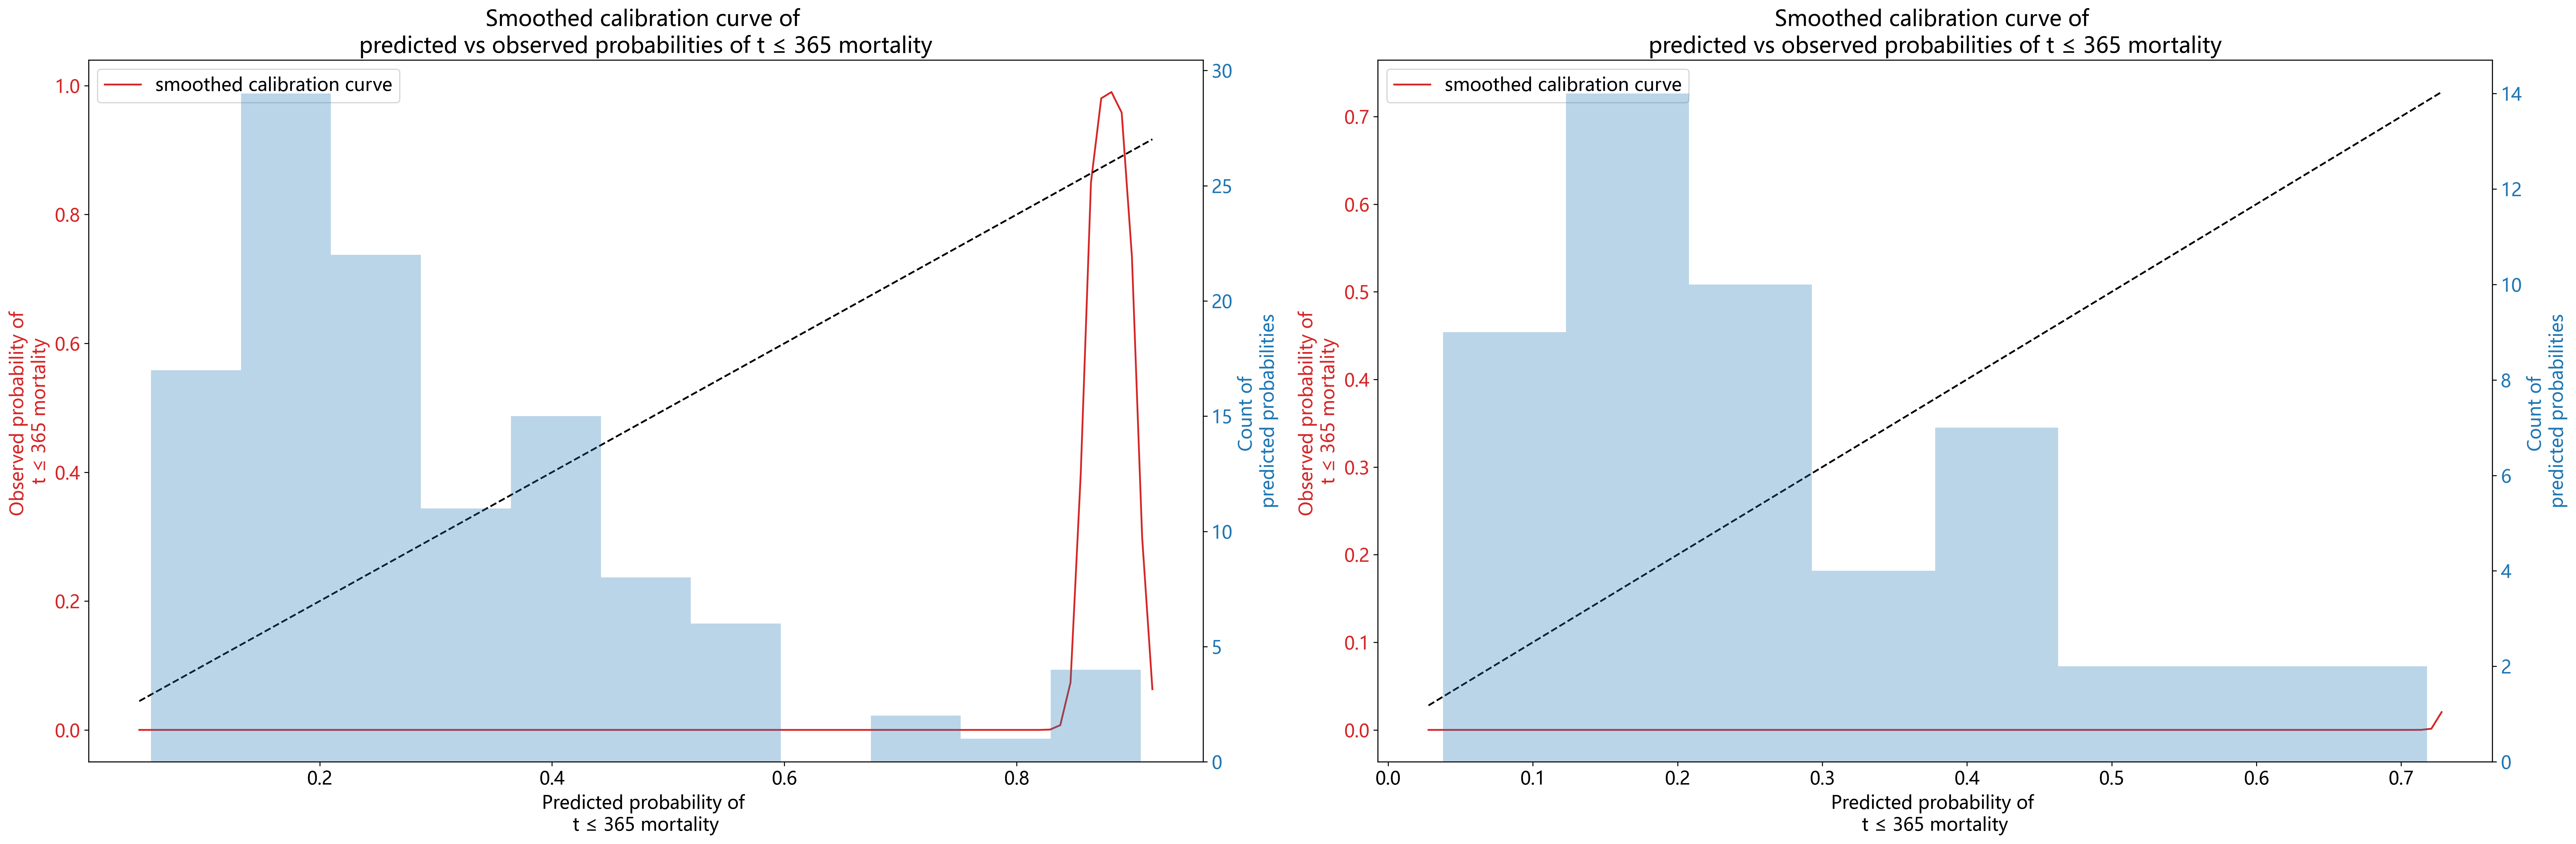

In [7]:
from lifelines.calibration import survival_probability_calibration
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
#训练集的校准曲线，t0 ( float ) – 评估事件发生概率的时间
survival_probability_calibration(cph, val_datasets['train'], t0=365*1, ax=axes[0])
#验证集的校准曲线
survival_probability_calibration(cph, val_datasets['test'], t0=365*1, ax=axes[1])
plt.savefig(f'img/{task_type}_cali.svg')
plt.show()

In [8]:
import os
import numpy as np

def get_prediction(model: CoxPHFitter, data, ID=None, **kwargs):
    hr = model.predict_partial_hazard(data)
    expectation = model.predict_expectation(data)
    
    predictions = pd.concat([hr, expectation], axis=1)
    predictions.columns = ['HR', 'expectation']
    if ID is not None:
        predictions = pd.concat([ID, hr, expectation], axis=1)
        predictions.columns = ['ID', 'HR', 'expectation']
    else:
        predictions = pd.concat([hr, expectation], axis=1)
        predictions.columns = ['HR', 'expectation']
    return predictions
os.makedirs('results', exist_ok=True)
kids = []
for subset, test_data in val_datasets.items():
    resuslts = get_prediction(cph, test_data, ID=test_data['ID'])
    resuslts.to_csv(f'results/{task_type}cox_predictions_{subset}.csv', index=False)
    kids.append(resuslts['ID'])